In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

In [15]:
### FASE DE ENTRENAMIENTO ###
# Intervalos de la variable independiente para entrenar

# Intervalos de las variables parametricas
parameters_min = [0, 1.42, 0.142] # t, a, b
parameters_max = [60, 1.43, 0.143] # t, a, b

# a_min = 1.42
# a_max = 1.43

# b_min = 0.142
# b_max = 0.143

# Cantidad de valores a entrenar dentro del rango correspondiente
numbers_of_var = [230, 230, 230] # ti, ai, bi

# Condiciones Iniciales
x0 = [1 - 1e-1, 1e-1, 0, 0] # s0, i0, r0, t0
N = 1

# Sistema de Funciones (Derivadas)
y = [
    lambda t, s, i: -t[:, 1] * s * i,
    lambda t, s, i: t[:, 1] * s * i - t[:, 2] * i,
    lambda t, s, i: t[:, 2] * i
]

if len(parameters_min) != len(parameters_max) or len(parameters_max) != len(numbers_of_var):
    raise Exception("Debe asignar valores minimos, maximos y cantidad de samples para cada epoca de entrenamiento, para cada paramentro del sistema incluyendo t")

if len(y) != len(x0) - 1:
    raise Exception("Debe asiganr una condicion inicial para cada ecuacion del sistema mas una para t0")



In [16]:
n_in = len(
    numbers_of_var
)  # El número de entradas depende de los parámetros de las funciones
n_out = len(
    y
)  # El número de salidas corresponde a la cantidad de ecuaciones del sistema

# Perceptrón multicapa
Ns = nn.Sequential(
    nn.Linear(n_in, 100, bias=True),
    nn.Sigmoid(),
    nn.Linear(100, n_out, bias=True),
)
Ns = Ns.double()

# Solución paramétrica que garantiza la condición inicial


# Psi = [(lambda t: x0[copy(i)] + (t[:, 0] - x0[-1]) * Ns(t)[:, copy(i)]) for i in range(len(y))]

Psi = [lambda t, i=i: x0[i] + (t[:, 0] - x0[-1]) * Ns(t)[:, i] for i in range(len(y))]

# Criterio de mínimos cuadrados en la función de pérdida
criterion = torch.nn.MSELoss()
# Descenso gradiente (Propagación hacia atrás resiliente)
optimizer_s = torch.optim.Rprop(Ns.parameters(), lr=0.005)

# Se inicializa un rango de entrenamiento con valores de t cercanos para que el aprendizaje de la red sea más objetivo
xi = [
    np.random.uniform(parameters_min[i], parameters_max[i], numbers_of_var[i])
    for i in range(len(numbers_of_var))
]

t = torch.empty((numbers_of_var[0], 0))
# Creación de un tensor con todos los parámetros de las funciones

for i in range(len(numbers_of_var)):
    t = np.insert(t, t.shape[1], xi[i], 1)

t = torch.Tensor(t).double()


# Función de Pérdida
def loss(t):
    t.requires_grad = True
    outputs = [Psi[i](t) for i in range(len(y))]

    grads = [
        torch.autograd.grad(
            outputs[i], t, grad_outputs=torch.ones_like(outputs[i]), create_graph=True
        )[0]
        for i in range(len(y))
    ]

    criterio = sum(
        [
            criterion(grads[i][:, 0], y[i](t, outputs[0], outputs[1]))
            for i in range(len(y))
        ]
    )  # Suma de los mínimos cuadrados entre la evaluación en la derivada y los valores de la red por cada ecuación
    return criterio


# Clausura (uso del optimizador)
def closure_s():
    # Nuevo conjunto por cada iteración
    xi = [
        np.random.uniform(parameters_min[i], parameters_max[i], numbers_of_var[i])
        for i in range(len(numbers_of_var))
    ]

    t = torch.empty((numbers_of_var[0], 0))
    # Creación de un tensor con todos los parámetros de las funciones

    for i in range(len(numbers_of_var)):
        t = np.insert(t, t.shape[1], xi[i], 1)

    t = torch.Tensor(t).double()

    optimizer_s.zero_grad()
    ls = loss(t)  # Evaluación en la función de pérdida
    ls.backward()  # Propagación hacia atrás resiliente
    return ls


# Iterando para optimizar
er_s = torch.inf
epochs = 10000
for e in range(epochs):
    er_s = optimizer_s.step(closure_s)
    print(f"epoch: {e +1}: {er_s}")


epoch: 1: 29582.57589848086
epoch: 2: 2438.2117314245857
epoch: 3: 117.04271613504065
epoch: 4: 14.189513273415374
epoch: 5: 55.28984769897012
epoch: 6: 85.41459887393039
epoch: 7: 11.419322646398399
epoch: 8: 0.4113474857472493
epoch: 9: 31.15637156246999
epoch: 10: 2.2355498785686088
epoch: 11: 3.6624646052197596
epoch: 12: 0.37325568759415384
epoch: 13: 0.09158822813754083
epoch: 14: 0.17878730622814507
epoch: 15: 0.1828873257036133
epoch: 16: 0.010483655792092381
epoch: 17: 0.14695585923645418
epoch: 18: 0.19725228266310874
epoch: 19: 0.016318394699720257
epoch: 20: 0.01460982965264421
epoch: 21: 0.011432069244133352
epoch: 22: 0.006286910955568367
epoch: 23: 0.005476296972183778
epoch: 24: 0.007539522712013868
epoch: 25: 0.0049163420262677004
epoch: 26: 0.004605978081691551
epoch: 27: 0.0060638257345307445
epoch: 28: 0.006109645611237884
epoch: 29: 0.004177641665574162
epoch: 30: 0.003936871498899321
epoch: 31: 0.003620215199004473
epoch: 32: 0.004326940105808623
epoch: 33: 0.0031

<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:53: SyntaxWarning: invalid escape sequence '\%'
C:\Users\emrys\AppData\Local\Temp\ipykernel_12084\2925699903.py:53: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel("$Personas(\%)$")


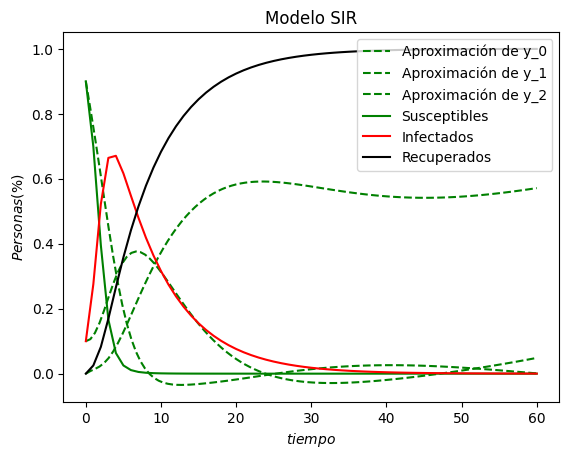

In [22]:
# Fase de Prueba
alpha = 1.4247
beta = 0.14286
xi[0] = torch.linspace(0, 60, 100)
xi[1] = np.full(100, alpha)
xi[2] = np.full(100, beta)

tt = torch.empty((100, 0))

for i in range(len(y)):
    tt = np.insert(tt, tt.shape[1], xi[i], 1)
tt = torch.Tensor(tt)

with torch.no_grad():
    s = [Psi[i](torch.Tensor(tt).double()) for i in range(len(y))]

fig, ax = plt.subplots(dpi=100)
for i in range(len(y)):
    ax.plot(xi[0], s[i] * N, "--", color="green", label=f'Aproximación de y_{i}')

# Comprobación con la función real
import scipy.integrate as spi

# Condiciones Iniciales
alpha = 1.4247
beta = 0.14286
x0[0] = 1 - 1e-1
x0[1] = 1e-1
x0[-1] = 0.0
N = 1
input = (x0[0], x0[1], x0[-1])

def diff_eqs(INP, t):
    y = np.zeros((3))
    s, i, _ = INP
    y[0] = -alpha * s * i
    y[1] = alpha * s * i - beta * i
    y[2] = beta * i
    return y

t_start = 0.0
t_end = parameters_max[0]
t_inc = 1.0
t_range = np.arange(t_start, t_end + t_inc, t_inc)
sir = spi.odeint(diff_eqs, input, t_range)

# Gráfica Real
ax.plot(sir[:, 0] * N, "-g", label="Susceptibles")
ax.plot(sir[:, 1] * N, "-r", label="Infectados")
ax.plot(sir[:, 2] * N, "-k", label="Recuperados")
plt.title("Modelo SIR")
ax.set_xlabel("$tiempo$")
ax.set_ylabel("$Personas(\%)$")
plt.legend(loc="best")
plt.show()